In [1]:
# loading modules
import ee
import geemap
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# initialize ee 
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()


# import all FMSE py functions 
from FMSE import *


## Area of Interest

### a) Through filtering ADM2 boundaries

In [2]:
city = 'Shikarpur'
city_shp = ee.FeatureCollection('projects/earthengine-legacy/assets/projects/sat-io/open-datasets/geoboundaries/CGAZ_ADM2')\
    .filter(ee.Filter.eq('shapeName', city))

def boundary(feature):
    bbox = feature.geometry().bounds()
    boundary = ee.Geometry.Polygon(bbox.coordinates().get(0))
    return boundary#ee.Feature(boundary)

aoi = boundary(city_shp)

### b) Through Drawing shape on map 

In [2]:
# load the map and then draw any shape on it
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# get drawm layer from map
aoi = Map.draw_last_feature
aoi.getInfo()

### c) Through providing shape of geometry as EE object

In [ ]:
# test areas
aoi = ee.Geometry.Polygon([[[67.571411, 26.280487],
    [67.571411, 26.587913],
    [68.083649, 26.587913],
    [68.083649, 26.280487],
    [67.571411, 26.280487]]])

#aoi = ee.Geometry.Polygon(
#    [[[67.98392410136336, 26.049909335428502],
#      [67.98392410136336, 25.42892423506662],
#      [68.59778518534773, 25.42892423506662],
#      [68.59778518534773, 26.049909335428502]]])

In [5]:
# CASE 1: Pakistan Floods 2022
# inputs
# Define the Area of Interest (aoi)

name = 'shikarpur_test_2022'



startDate = ee.Date('2022-03-01')
endDate = ee.Date('2022-08-20')
predays = 60
postdays = 20

# optional
split = 0.9
zvv_value = -3
zvh_value = -3
water_value = 75
elev_value = 800
slope_value = 10
num_samples = 200
under_estimate = False



## Flood layer Masking

In [6]:
# Fetching pre and post-flood images
s1_pre = get_s1_col(startDate, predays, aoi).select(['VV', 'VH'])
s1_post = get_s1_col(endDate, postdays, aoi).select(['VV', 'VH'])

print('Images in S1 Pre: ', s1_pre.size().getInfo())
print('Images in S1 Post: ', s1_post.size().getInfo())

# Calculate Z-score
zscore = calculate_zscore(s1_pre, s1_post, aoi)

# Generate flood masks
flood_class, flood_layer = map_floods(zscore, aoi, zvv_value, zvh_value, water_value, elev_value, slope_value, under_estimate)

print('Done with flood masking...')

Images in S1 Pre:  20
Images in S1 Post:  6
Done with flood masking...


In [7]:
# Run flood mapping example
flood_binary = flood_mapping(aoi, s1_post, flood_layer, num_samples, split)
print('Done with flood mapping...')

Done with preparing datasets...
Done with creating sample feature collection...
Done with creating training and validation samples...
Done with classification...
Training Accuracy Metrics:
Overall Accuracy: 0.9916201117318436
Kappa: 0.9832391772527234
Producer's Accuracy: [[0.9943502824858758], [0.988950276243094]]
User's Accuracy: [[0.9887640449438202, 0.9944444444444445]]
F1 Score: 0.9916897506925207
Validation Accuracy Metrics:
Overall Accuracy: 0.7804878048780488
Kappa: 0.5633136094674556
Producer's Accuracy: [[0.7272727272727273], [0.8421052631578947]]
User's Accuracy: [[0.8421052631578947, 0.7272727272727273]]
F1 Score: 0.7804878048780488
Done with accuracy metrics...
Done with flood mapping...


In [8]:
# Run susceptibility analysis example
flood_susceptibility_prob = susceptibility_analysis(aoi, endDate, flood_binary, num_samples, split)
print('Done with susceptibility analysis...')

Done with preparing datasets for susceptibility analysis...
Size of label collection: 400
Bands for susceptibility analysis: ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'NDVI', 'NDWI', 'NDBI', 'elevation', 'slope', 'aspect']
Training sus first:  {'type': 'Feature', 'geometry': None, 'id': '0_0', 'properties': {'NDBI': -0.13394486904144287, 'NDVI': 0.5329299569129944, 'NDWI': -0.5066957473754883, 'SR_B1': 0.0353725, 'SR_B2': 0.04866875, 'SR_B3': 0.08481749999999999, 'SR_B4': 0.07893249999999999, 'SR_B5': 0.2590575, 'SR_B6': 0.19785625, 'SR_B7': 0.12577875, 'aspect': 290.5562438964844, 'elevation': 61, 'label': 1, 'random': 0.4544056470284594, 'slope': 0.2772780954837799}}
Validation F1 Score: 0.5789473684210527
Validation Producer Accuracy: [0.4782608695652174]
Validation Consumer Accuracy: None
Done with susceptibility analysis...


In [9]:
def quantile_based_categorization(susceptibility_layer, aoi):
    """
    Convert a continuous flood susceptibility layer into five categorical classes based on quantiles.

    Parameters:
    susceptibility_layer (ee.Image): Continuous flood susceptibility layer with values between 0 and 1.
    aoi (ee.Geometry): Area of Interest for calculating quantiles.

    Returns:
    ee.Image: Categorical flood susceptibility layer with values from 1 to 5.
    """
    # Calculate quantiles for the susceptibility layer
    quantiles = susceptibility_layer.reduceRegion(
        reducer=ee.Reducer.percentile([20, 40, 60, 80], ['p20', 'p40', 'p60', 'p80']),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    )
    #print('Quantiles:', quantiles.getInfo())
    # Extract quantile values
    q20 = quantiles.get('classification_p20')
    q40 = quantiles.get('classification_p40')
    q60 = quantiles.get('classification_p60')
    q80 = quantiles.get('classification_p80')

    # Apply quantile thresholds to create categorical classes
    very_low = susceptibility_layer.lte(ee.Number(q20)).multiply(1)
    low = susceptibility_layer.gt(ee.Number(q20)).And(susceptibility_layer.lte(ee.Number(q40))).multiply(2)
    moderate = susceptibility_layer.gt(ee.Number(q40)).And(susceptibility_layer.lte(ee.Number(q60))).multiply(3)
    high = susceptibility_layer.gt(ee.Number(q60)).And(susceptibility_layer.lte(ee.Number(q80))).multiply(4)
    very_high = susceptibility_layer.gt(ee.Number(q80)).multiply(5)

    # Combine all classes into a single layer
    categorical_layer = very_low.add(low).add(moderate).add(high).add(very_high).rename('susceptibility')

    return categorical_layer

sus_catagory = quantile_based_categorization(flood_susceptibility_prob, aoi)


In [12]:
Map.addLayer(flood_class, {'min': 0, 'max': 4, 'palette': ['#FFFFFF','#FFA500','#FFFF00','#FF0000','#0000FF']}, 'Flood class')# non-flooded, vv, vh, vv+vh, water
Map.addLayer(flood_layer, {'min': 1, 'max': 2, 'palette': ['blue', 'white']}, 'Flood layer')
Map.addLayer(flood_binary, {'min': 1, 'max': 2, 'palette': ['blue', 'white']}, 'Flood Binary')
Map.addLayer(flood_susceptibility_prob, {'min': 0.1, 'max': 0.9, 'palette': ['#2c7bb6', '#abd9e9', '#ffffbf', '#fdae61', '#d7191c']}, 'Flood Susceptibility')

Map.addLayer(sus_catagory, {'min': 1, 'max': 5, 'palette': ['#2c7bb6', '#abd9e9', '#ffffbf', '#fdae61', '#d7191c']}, 'Flood Susceptibility Categorical')
Map

Map(center=[27.950384742540557, 68.60645442019576], controls=(WidgetControl(options=['position', 'transparent_…

# Exposure Analysis

## Population Exposed to Floods

Total population: 2945851
Total population exposed to flood: 712141


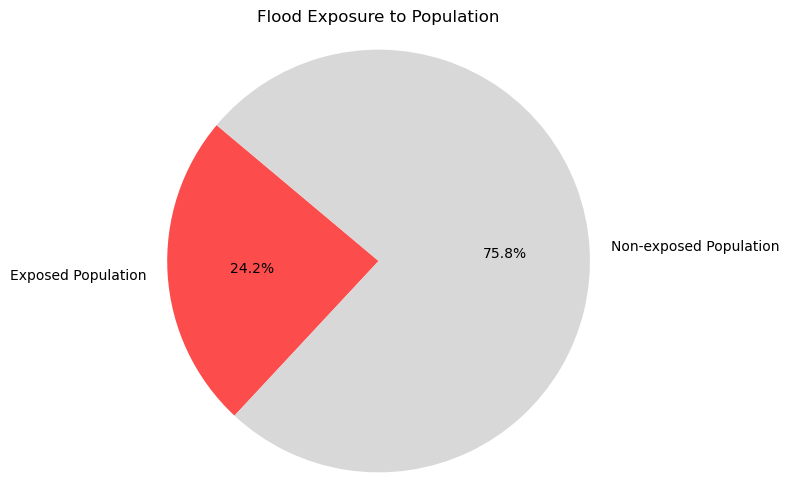

In [10]:

def calculate_flood_exposure(flood_binary, aoi):
    """
    Calculate the population exposed to the flood based on the flood layer.

    Parameters:
    flood_layer (ee.Image): Flood layer with values 1 for flooded and 2 for non-flooded.
    population_dataset (str): Path to the population dataset.
    aoi (ee.Geometry): Area of Interest.

    Returns:
    ee.Number: Total population exposed to the flood.
    """
    # Load population dataset
    population = ee.ImageCollection('WorldPop/GP/100m/pop')\
                    .filter(ee.Filter.eq('year', 2020))\
                    .mosaic()\
                    .clip(aoi)
    
    # Mask non-flooded areas
    flood_exposure = population.updateMask(flood_binary.eq(1))
    
    # Calculate total exposed population
    total_exposed_population = flood_exposure.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=90,
        maxPixels=1e12
    ).get('population')
    
     # Calculate total population in the study area
    total_population = population.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=90,
        maxPixels=1e12
    ).get('population')
    
    return total_exposed_population, total_population

def visualize_flood_exposure(total_exposed_population, total_population):
    
    """
    Visualize flood exposure as a pie chart.

    Parameters:
    total_exposed_population (ee.Number): Total population exposed to the flood.
    total_population (ee.Number): Total population in the study area.
    """
    exposed_population = total_exposed_population.getInfo()
    total_pop = total_population.getInfo()
    non_exposed_population = total_pop - exposed_population
    
    labels = ['Exposed Population', 'Non-exposed Population']
    sizes = [exposed_population, non_exposed_population]
    colors = ['#fc4d4c', '#d8d8d8']  # Tomato color for exposed population, light green for non-exposed population
    
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title('Flood Exposure to Population')
    plt.show()

total_exposed_population, total_population = calculate_flood_exposure(flood_binary, aoi)

# print total population without decimal points
print('Total population:', int(total_population.getInfo()))
print('Total population exposed to flood:', int(total_exposed_population.getInfo()))

visualize_flood_exposure(total_exposed_population, total_population)


In [15]:

def calculate_exposure_df(susceptibility_layer, aoi, flood_map=False):
    """
    Calculate exposure for population, nighttime light, and land cover for each susceptibility level or flood map.

    Parameters:
    susceptibility_layer (ee.Image): Flood susceptibility layer or flood map.
    population_dataset (str): Path to the population dataset.
    nightlight_dataset (str): Path to the nighttime light dataset.
    landcover_dataset (str): Path to the land cover dataset.
    aoi (ee.Geometry): Area of Interest.
    flood_map (bool): Flag to indicate if susceptibility categories or flood map should be used.

    Returns:
    pd.DataFrame: Dataframe with exposure information.
    """
        # Define remap function for landcover
    def remapper(image):
        return image.remap([1, 2, 4, 5, 7, 8, 9, 10, 11], [1, 2, 3, 4, 5, 6, 7, 8, 9])

    # Load datasets
    population = ee.ImageCollection('WorldPop/GP/100m/pop')\
                    .filter(ee.Filter.eq('year', 2020))\
                    .mosaic()\
                    .clip(aoi).rename('b1')
    nightlight = ee.Image('projects/sat-io/open-datasets/npp-viirs-ntl/LongNTL_2022').clip(aoi).rename('b1')
    landcover = ee.ImageCollection('projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m_TS')\
                    .filterDate('2022-01-01', '2022-12-31')\
                    .map(remapper)\
                    .mosaic().clip(aoi).rename('b1')
    

    # Initialize results dictionary with descriptive land cover names
    results = {
        'Susceptibility Level': [],
        'Exposed Population': [],
        'Exposed Nighttime Light': [],
        'lulc_water': [],
        'lulc_trees': [],
        'lulc_flooded_vegetation': [],
        'lulc_crops': [],
        'lulc_built_area': [],
        'lulc_bare_ground': [],
        'lulc_snow_ice': [],
        'lulc_clouds': [],
        'lulc_rangeland': [],
        'Category': []
    }
    
    if flood_map:
        susceptibility_levels = [1]
        susceptibility_layer = susceptibility_layer.gt(0).selfMask()
        category_names = ['Flooded']
    else:
        # Define quantile-based categories
        susceptibility_levels = range(1, 6)
        category_names = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
    
    # Calculate exposure for each susceptibility level
    for level, category in zip(susceptibility_levels, category_names):
        # Mask areas that do not match the current susceptibility level
        level_mask = susceptibility_layer.eq(level)
        level_population = population.updateMask(level_mask)
        level_nightlight = nightlight.updateMask(level_mask)
        level_landcover = landcover.updateMask(level_mask)

        # Calculate total exposed population
        exposed_population = level_population.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=aoi,
            scale=1000,
            maxPixels=1e12
        ).get('b1').getInfo()

        # Calculate total exposed nighttime light
        exposed_nightlight = level_nightlight.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=aoi,
            scale=1000,
            maxPixels=1e12
        ).get('b1').getInfo()

        # Calculate land cover area for each class
        landcover_areas = level_landcover.reduceRegion(
            reducer=ee.Reducer.frequencyHistogram(),
            geometry=aoi,
            scale=1000,
            maxPixels=1e12
        ).get('b1').getInfo()

        # Append results to the dictionary
        results['Susceptibility Level'].append(level)
        results['Category'].append(category)
        results['Exposed Population'].append(exposed_population)
        results['Exposed Nighttime Light'].append(exposed_nightlight)
        landcover_classes = {
            'lulc_water': 1,
            'lulc_trees': 2,
            'lulc_flooded_vegetation': 3,
            'lulc_crops': 4,
            'lulc_built_area': 5,
            'lulc_bare_ground': 6,
            'lulc_snow_ice': 7,
            'lulc_clouds': 8,
            'lulc_rangeland': 9
        }
        for lulc_name, lulc_code in landcover_classes.items():
            results[lulc_name].append(landcover_areas.get(str(lulc_code), 0))
        
    # Convert results to dataframe
    df = pd.DataFrame(results)
    return df


# Calculate exposure dataframe
exposure_df = calculate_exposure_df(sus_catagory, aoi, flood_map=False)
exposure_df = exposure_df.round(2)
# save df as csv
exposure_df.to_csv(f'{city}_exposure_df.csv', index=False)
print(exposure_df)


   Susceptibility Level  Exposed Population  Exposed Nighttime Light  \
0                     1         3812.484643               155.261362   
1                     2         3752.265221               104.842657   
2                     3         4630.435431               307.137854   
3                     4         6312.540646               401.194106   
4                     5         5975.105851               509.537804   

   lulc_water  lulc_trees  lulc_flooded_vegetation  lulc_crops  \
0    3.000000           8                        4  669.062745   
1   23.576471           5                        8  596.988235   
2   25.623529           0                        9  690.247059   
3   27.200000           1                        4  749.905882   
4   58.152941           4                        4  862.784314   

   lulc_built_area  lulc_bare_ground  lulc_snow_ice  lulc_clouds  \
0         2.576471          1.000000              0            0   
1        15.576471          5.0000

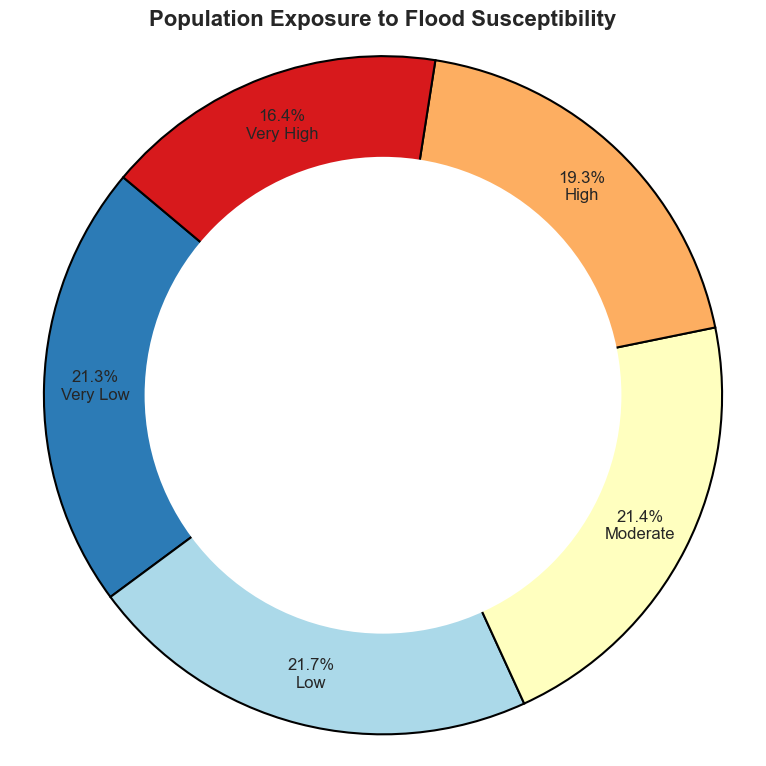

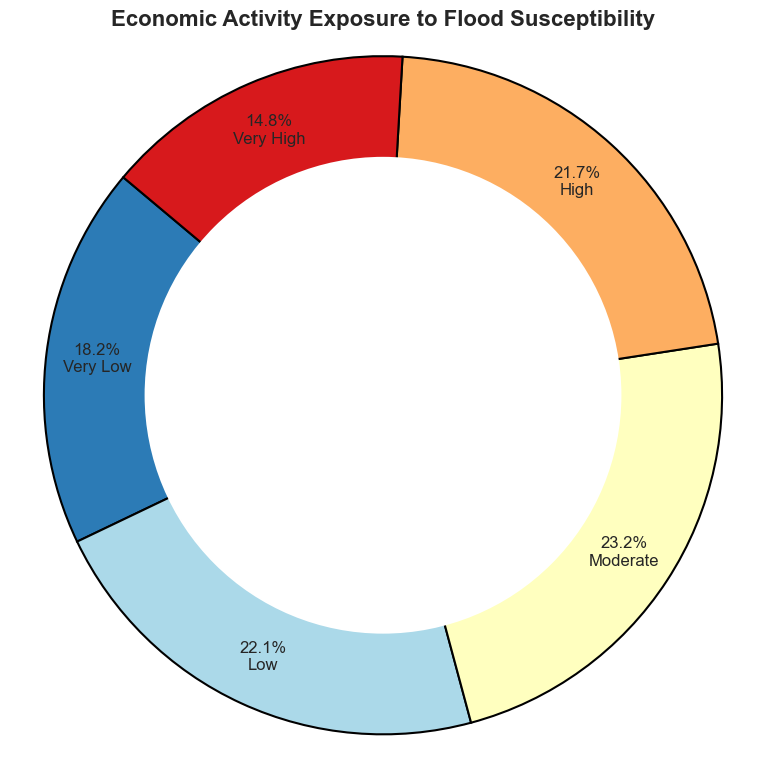

C:\Users\walee\AppData\Local\Temp\ipykernel_37628\3404606333.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=landcover_data_sorted.index, y=landcover_data_sorted.values, palette="YlOrRd_r", ax=ax)
C:\Users\walee\AppData\Local\Temp\ipykernel_37628\3404606333.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
C:\Users\walee\AppData\Local\Temp\ipykernel_37628\3404606333.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=landcover_data_sorted.index, y=landcover_data_sorted.values, palette="YlOrRd_r", ax=ax)
C:\Users\wale

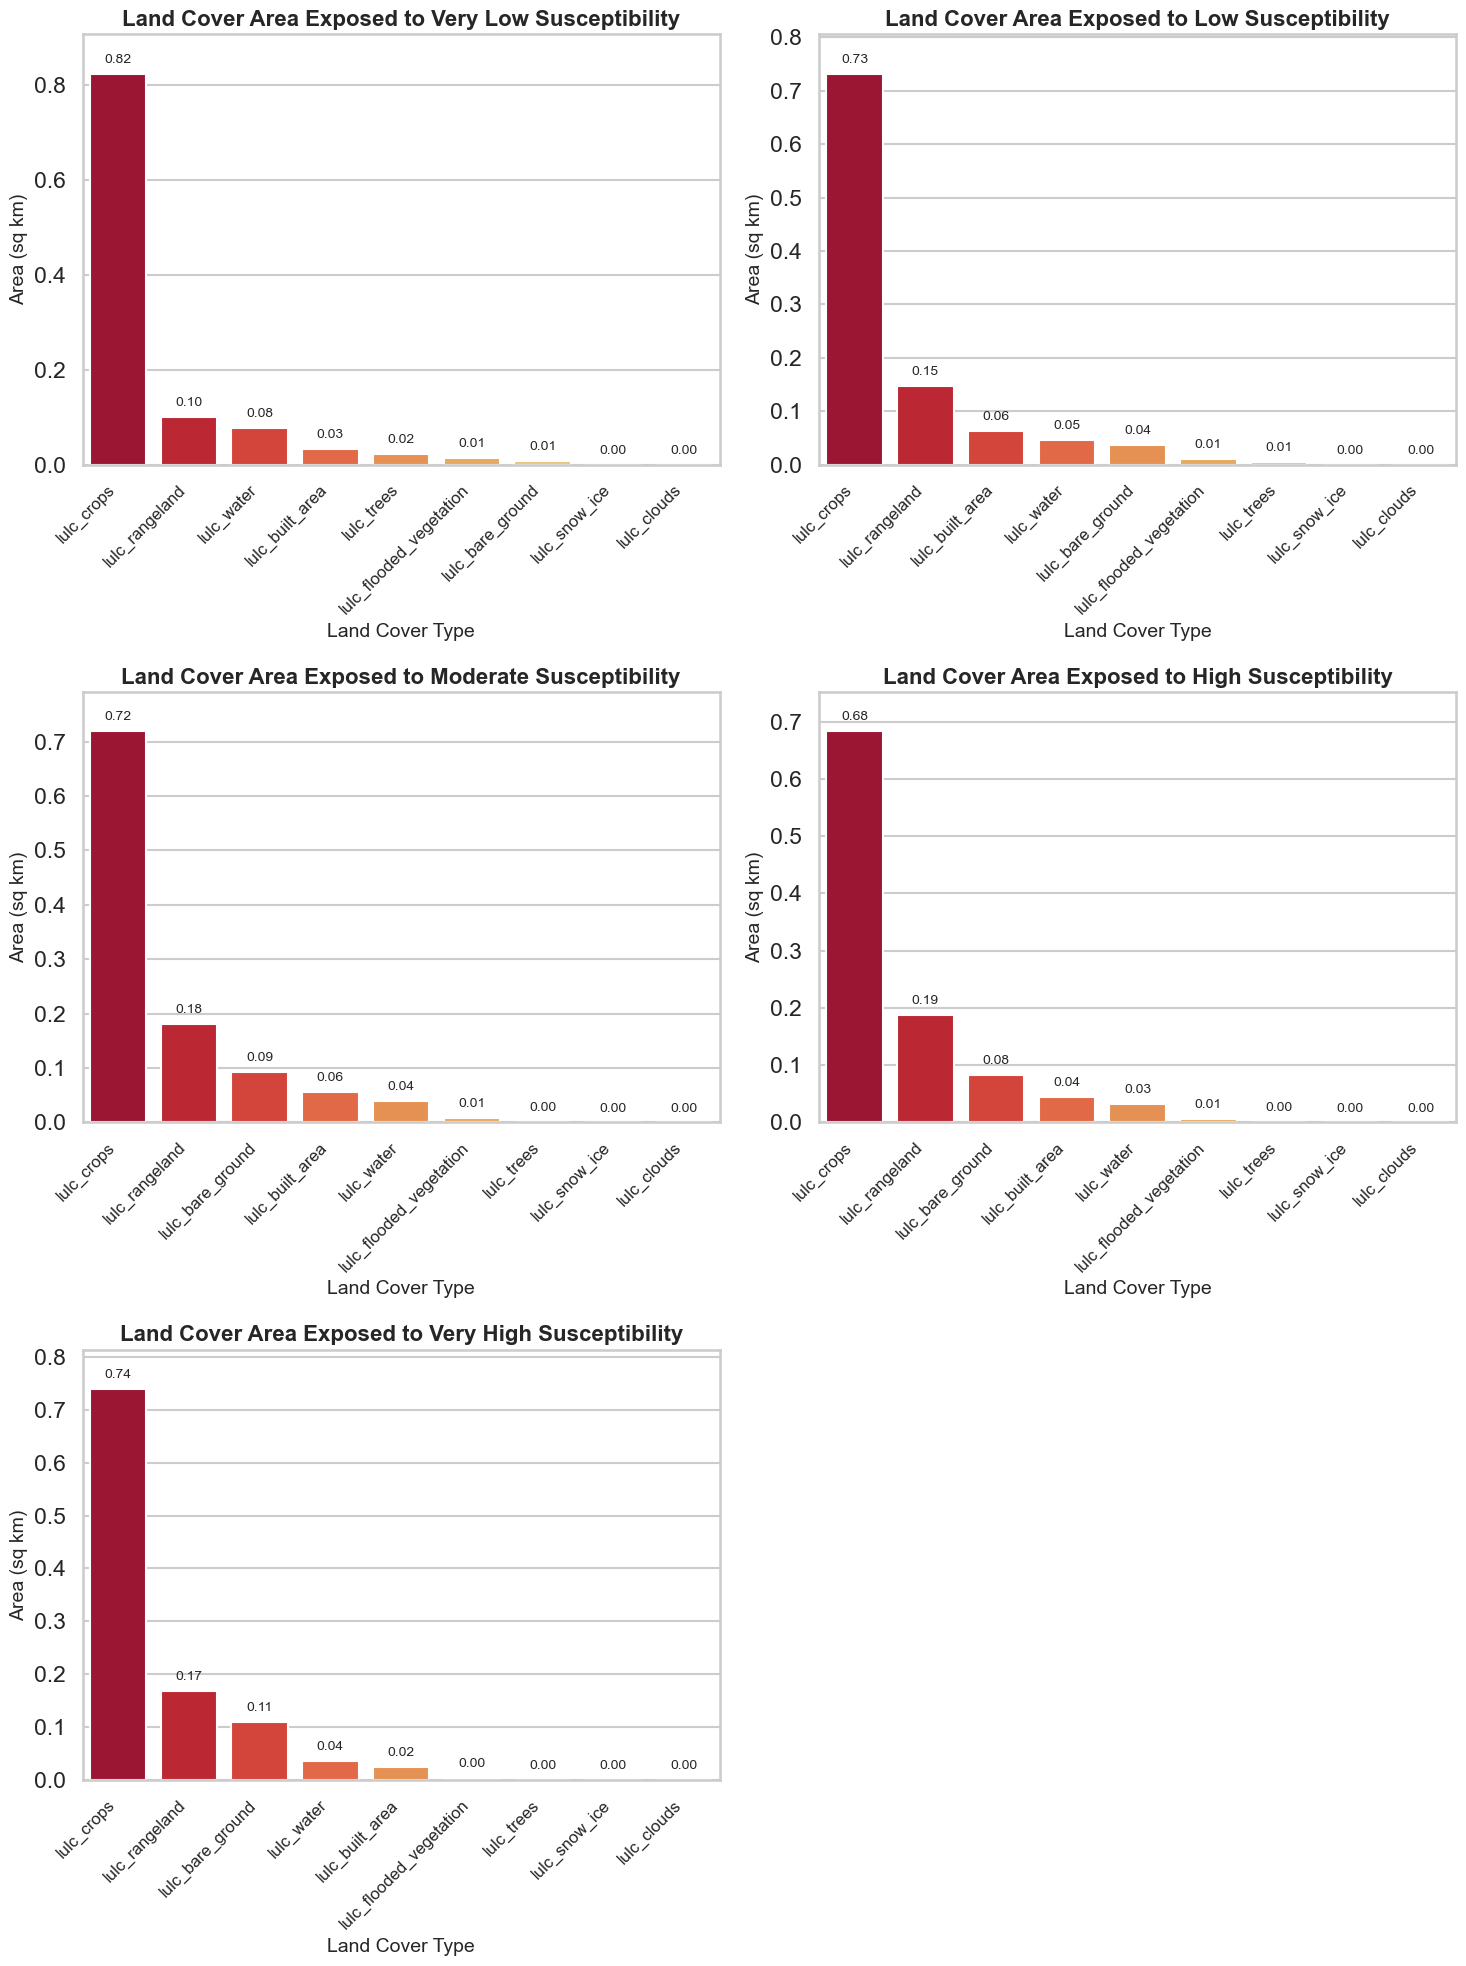

In [12]:
def visualize_exposure(df):
    """
    Generate visualizations for exposure analysis:
    1. A donut chart for population exposure to susceptibility per class.
    2. A donut chart for economic activity (nighttime light) exposure per susceptibility class.
    3. Five combined subplot charts for land cover area exposure for each flood susceptibility class.

    Parameters:
    df (pd.DataFrame): Dataframe containing exposure information.
    """

    # Colors for each susceptibility class
    colors = ['#2c7bb6', '#abd9e9', '#ffffbf', '#fdae61', '#d7191c']
    labels = df['Category'].tolist()
    
    # Function to create donut charts
    def create_donut_chart(data, title, labels):
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))
        wedges, texts, autotexts = ax.pie(data, labels=None, autopct='', startangle=140,
                                          colors=colors, pctdistance=0.85,
                                          wedgeprops={'edgecolor': 'black'})
        
        for i, a in enumerate(autotexts):
            percentage = f"{data[i]/sum(data)*100:.1f}%"
            label = labels[i]
            autotexts[i].set_text(f"{percentage}\n{label}")
            autotexts[i].set_fontsize(12)

        centre_circle = plt.Circle((0,0),0.70,fc='white')
        fig.gca().add_artist(centre_circle)
        plt.title(title, fontsize=16, fontweight='bold')
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

    # Donut chart for population exposure
    create_donut_chart(df['Exposed Population'], 'Population Exposure to Flood Susceptibility', labels)

    # Donut chart for economic activity (nighttime light) exposure
    create_donut_chart(df['Exposed Nighttime Light'], 'Economic Activity Exposure to Flood Susceptibility', labels)

    # Land cover columns
    landcover_columns = [
        'lulc_water', 'lulc_trees', 'lulc_flooded_vegetation', 'lulc_crops',
        'lulc_built_area', 'lulc_bare_ground', 'lulc_snow_ice', 'lulc_clouds', 'lulc_rangeland'
    ]

    # Create subplots for land cover area exposure
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    axes = axes.flatten()

    for i, (category, row) in enumerate(df.iterrows()):
        landcover_data = row[landcover_columns] / 1e6  # Convert from m^2 to km^2
        landcover_data_sorted = landcover_data.sort_values(ascending=False)
        ax = axes[i]
        sns.barplot(x=landcover_data_sorted.index, y=landcover_data_sorted.values, palette="YlOrRd_r", ax=ax)

        # Adjust the positioning of the text labels on the bars
        for bar in ax.patches:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02 * landcover_data_sorted.max(), f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

        ax.set_title(f'Land Cover Area Exposed to {row["Category"]} Susceptibility', fontsize=16, fontweight='bold')
        ax.set_ylabel('Area (sq km)', fontsize=14)
        ax.set_xlabel('Land Cover Type', fontsize=14)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
        ax.set_ylim(0, landcover_data_sorted.max() * 1.1)
        ax.set_facecolor('white')

    # Remove the unused subplot
    fig.delaxes(axes[-1])

    plt.tight_layout()
    plt.show()

# Apply the ggplot theme
sns.set_theme(style="whitegrid")
sns.set_context("talk")

# Example usage
visualize_exposure(exposure_df)


## Optional Model tuning and comparison

In [ ]:
# test code to compare models

# Parameters
num_samples = 1000  # Number of sample points
split = 0.8  # Train-test split ratio
bands = ['VV', 'VH']  # Bands to use for classification

# Create the 'sample' feature collection
sample = flood_layer.stratifiedSample(
    numPoints=num_samples,
    classBand='label',
    region=aoi,
    scale=10,
    seed=5,
    tileScale=1.5,
    geometries=True
)

# Update label values: change non-flood (label 2) to 0
def updateFeature(feature):
    value = feature.get('label')
    updated_value = ee.Algorithms.If(ee.Algorithms.IsEqual(value, ee.Number(2)), ee.Number(0), value)
    return feature.set('label', updated_value)

label = sample.map(updateFeature)

# Verify label values
unique_labels = label.aggregate_array('label').distinct().getInfo()
print(f"Unique labels: {unique_labels}")

# Prepare image for classification
image = s1_post.mean().clip(aoi)

# Create training and validation samples
sample_all = image.select(bands).sampleRegions(
    collection=label,
    properties=['label'],
    scale=10
).randomColumn()

training = sample_all.filter(ee.Filter.lt('random', split))
validation = sample_all.filter(ee.Filter.gte('random', split))

# Define classifiers to compare
classifiers = {
    'RandomForest': ee.Classifier.smileRandomForest(115),
    'GradientTreeBoost': ee.Classifier.smileGradientTreeBoost(100),
    'DecisionTree': ee.Classifier.smileCart(),
    #'NaiveBayes': ee.Classifier.smileNaiveBayes(),
    'SVM': ee.Classifier.libsvm()
}

def evaluate_classifier(classifier, training, validation):
    start_time = time.time()
    
    trained_classifier = classifier.train(
        features=training,
        classProperty='label',
        inputProperties=bands
    )
    
    training_classified = training.classify(trained_classifier)
    validation_classified = validation.classify(trained_classifier)
    
    training_accuracy = training_classified.errorMatrix('label', 'classification')
    validation_accuracy = validation_classified.errorMatrix('label', 'classification')
    
    end_time = time.time()
    prediction_time = end_time - start_time
    
    return {
        'train_f1': training_accuracy.fscore().getInfo()[1] if len(training_accuracy.fscore().getInfo()) > 1 else None,
        'validation_f1': validation_accuracy.fscore().getInfo()[1] if len(validation_accuracy.fscore().getInfo()) > 1 else None,
        'train_producer_accuracy': training_accuracy.producersAccuracy().getInfo()[1] if len(training_accuracy.producersAccuracy().getInfo()) > 1 else None,
        'validation_producer_accuracy': validation_accuracy.producersAccuracy().getInfo()[1] if len(validation_accuracy.producersAccuracy().getInfo()) > 1 else None,
        'train_consumer_accuracy': training_accuracy.consumersAccuracy().getInfo()[1] if len(training_accuracy.consumersAccuracy().getInfo()) > 1 else None,
        'validation_consumer_accuracy': validation_accuracy.consumersAccuracy().getInfo()[1] if len(validation_accuracy.consumersAccuracy().getInfo()) > 1 else None,
        'prediction_time': prediction_time
    }

# Evaluate all classifiers
results = {}
for name, classifier in classifiers.items():
    print(f"Evaluating {name} classifier...")
    results[name] = evaluate_classifier(classifier, training, validation)

# Print results
for name, metrics in results.items():
    print(f"\nClassifier: {name}")
    print(f"Training F1 Score: {metrics['train_f1']}")
    print(f"Validation F1 Score: {metrics['validation_f1']}")
    print(f"Training Producer Accuracy: {metrics['train_producer_accuracy']}")
    print(f"Validation Producer Accuracy: {metrics['validation_producer_accuracy']}")
    print(f"Training Consumer Accuracy: {metrics['train_consumer_accuracy']}")
    print(f"Validation Consumer Accuracy: {metrics['validation_consumer_accuracy']}")
    print(f"Prediction Time: {metrics['prediction_time']} seconds")

# Optionally, export the best classifier's results
# best_classifier_name = max(results, key=lambda k: results[k]['validation_f1'])
# best_classifier = classifiers[best_classifier_name].train(
#     features=training,
#     classProperty='label',
#     inputProperties=bands
# )
# classified_image = image.select(bands).classify(best_classifier)
# geemap.ee_export_image_to_drive(classified_image, description=f'best_classifier_{best_classifier_name}', folder='earth_engine', scale=10, region=aoi)


## Export Layers

In [17]:
import time

def export_layers(aoi, flood_binary, flood_class, flood_mapped, susceptibility_layer, susceptibility_category_layer,
                  export_flood_binary=True, export_flood_class=True, export_flood_mapped=True,
                  export_susceptibility_layer=True, export_susceptibility_category_layer=True):
    """
    Export specified layers to Google Drive.

    Parameters:
    aoi (ee.Geometry): Area of Interest.
    flood_binary (ee.Image): Flood binary layer.
    flood_class (ee.Image): Flood class layer.
    flood_mapped (ee.Image): Flood mapped layer.
    susceptibility_layer (ee.Image): Susceptibility layer.
    susceptibility_category_layer (ee.Image): Susceptibility category layer.
    export_flood_binary (bool): Flag to export flood binary layer.
    export_flood_class (bool): Flag to export flood class layer.
    export_flood_mapped (bool): Flag to export flood mapped layer.
    export_susceptibility_layer (bool): Flag to export susceptibility layer.
    export_susceptibility_category_layer (bool): Flag to export susceptibility category layer.
    """

    tasks = []
    aoi = aoi.geometry()
    if export_flood_binary:
        flood_binary_task = ee.batch.Export.image.toDrive(
            image=flood_binary,
            description=f'{city}_flood_mask_layer',
            folder='FMSE',
            scale=10,
            region=aoi,
            maxPixels=1e13
        )
        flood_binary_task.start()
        tasks.append(flood_binary_task)

    if export_flood_class:
        flood_class_task = ee.batch.Export.image.toDrive(
            image=flood_class,
            description=f'{city}_flood_class_layer',
            folder='FMSE',
            scale=10,
            region=aoi,
            maxPixels=1e13
        )
        flood_class_task.start()
        tasks.append(flood_class_task)

    if export_flood_mapped:
        flood_mapped_task = ee.batch.Export.image.toDrive(
            image=flood_mapped,
            description=f'{city}_flood_mapped_layer',
            folder='FMSE',
            scale=10,
            region=aoi,
            maxPixels=1e13
        )
        flood_mapped_task.start()
        tasks.append(flood_mapped_task)

    if export_susceptibility_layer:
        susceptibility_task = ee.batch.Export.image.toDrive(
            image=susceptibility_layer,
            description=f'{city}_flood_susceptibility_layer',
            folder='FMSE',
            scale=30,
            region=aoi,
            maxPixels=1e13
        )
        susceptibility_task.start()
        tasks.append(susceptibility_task)

    if export_susceptibility_category_layer:
        susceptibility_category_task = ee.batch.Export.image.toDrive(
            image=susceptibility_category_layer,
            description=f'{city}_flood_susceptibility_category_layer',
            folder='FMSE',
            scale=30,
            region=aoi,
            maxPixels=1e13
        )
        susceptibility_category_task.start()
        tasks.append(susceptibility_category_task)

    def monitor_tasks(tasks):
        while any([task.status()['state'] in ['READY', 'RUNNING'] for task in tasks]):
            for task in tasks:
                status = task.status()
                description = status['description']
                state = status['state']
                print(f'Task {description} is {state}')
            time.sleep(30)  # Check every 30 seconds

    # Monitor the export tasks
    monitor_tasks(tasks)

export_layers(aoi, 
              flood_binary, flood_class, flood_binary, flood_susceptibility_prob, sus_catagory,
               export_flood_binary=True, 
               export_flood_class=True, 
               export_flood_mapped=True,
               export_susceptibility_layer=True, 
               export_susceptibility_category_layer=True)


Task Shikarpur_flood_mask_layer is READY
Task Shikarpur_flood_class_layer is READY
Task Shikarpur_flood_mapped_layer is READY
Task Shikarpur_flood_susceptibility_layer is READY
Task Shikarpur_flood_susceptibility_category_layer is READY
Task Shikarpur_flood_mask_layer is RUNNING
Task Shikarpur_flood_class_layer is RUNNING
Task Shikarpur_flood_mapped_layer is RUNNING
Task Shikarpur_flood_susceptibility_layer is READY
Task Shikarpur_flood_susceptibility_category_layer is READY
Task Shikarpur_flood_mask_layer is RUNNING
Task Shikarpur_flood_class_layer is RUNNING
Task Shikarpur_flood_mapped_layer is RUNNING
Task Shikarpur_flood_susceptibility_layer is READY
Task Shikarpur_flood_susceptibility_category_layer is READY
Task Shikarpur_flood_mask_layer is RUNNING
Task Shikarpur_flood_class_layer is RUNNING
Task Shikarpur_flood_mapped_layer is RUNNING
Task Shikarpur_flood_susceptibility_layer is READY
Task Shikarpur_flood_susceptibility_category_layer is READY
Task Shikarpur_flood_mask_layer is

In [47]:
# scale image between 1 to 100 (integers) and export
results_prob_scaled = results_prob.multiply(100).toInt()
geemap.ee_export_image(results_prob_scaled, filename='flood_susceptibility.tif', scale=30, region=aoi, file_per_band=False)

Generating URL ...
Please wait ...
An error occurred while downloading.
